In [49]:
import librosa
import pandas as pd
from librosa.effects import pitch_shift
import os
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.optimizers import adam_v2

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from keras.layers import Input, Conv1D, SeparableConv1D, MaxPooling1D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from librosa.effects import pitch_shift
from sklearn.metrics import classification_report
import os
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc
from sklearn import svm
import scipy.io.wavfile as wav
import scipy.signal as signal
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

KeyboardInterrupt: 

In [ ]:

features = []
labels = []
dataset_path: str = "C:\\Users\\rclendening\\researchData\\RedVox_TrainingBinary_wYTVids"
data_dir = pathlib.Path(dataset_path)
droneDict = {  # One hot encoding for labels probs should do it like I did below?
    "Drone": [1, 0],
    "Noise": [0, 1]
}
droneCountDict = {  # One hot encoding for labels
    "Noise": 0,
    "Drone": 1
}

dataCount = [0, 0]
train_files=[]
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        train_files.append(os.path.join(path, name))

def split_audio(waveData, labelName, sampleFreq):
    '''
    Frames audio data and converts to feature space (MFCC)
    :param waveData: waveData array of time-domain audio
    :param frame_duration: Duration of frames desired
    :param startTime: Start for each clip
    :param sampleFreq: Sample Frequency (8Khz)
    :param labelName: Name of label
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    # middle third of data
    duration = waveData.shape[0]
    startTime = np.round(duration / 3)
    endTime = np.round(duration * 2 / 3)
    waveDataSplit= waveData[int(startTime):int(endTime)]
    features=MFCCCalc(waveDataSplit.squeeze(), sampleFreq)
    dataCount[droneCountDict[labelName]] += features.shape[1]
    #label= [droneDict[labelName]] * features.shape[1]
    label= [droneCountDict[labelName]]*features.shape[1]
    return features, label
# def split_audio(waveData, labelName, sampleFreq,passName):
#     '''
#     Frames audio data and converts to feature space (MFCC)
#     :param waveData: waveData array of time-domain audio
#     :param frame_duration: Duration of frames desired
#     :param startTime: Start for each clip
#     :param sampleFreq: Sample Frequency (8Khz)
#     :param labelName: Name of label
#     @return list of features (ds), list of labels corresponding to feature dataset:
#     '''
#     if labelName == "Drone":
#     # middle third of data
#         #if  passName != "A3R9" and passName !="A3R1":
#         duration = waveData.shape[0]
#         startTime = np.round(duration / 3)
#         endTime = np.round(duration * 2 / 3)
#         waveDataSplit= waveData[int(startTime):int(endTime)]
#         features=MFCCCalc(waveDataSplit.squeeze(), sampleFreq)
#         # elif passName== "A3R9":
#         #     duration = waveData.shape[0]
#         #     startTime = 0
#         #     endTime = np.round(duration * 1 / 3)
#         #     waveDataSplit= waveData[int(startTime):int(endTime)]
#         #     features=MFCCCalc(waveDataSplit.squeeze(), sampleFreq)
#         # elif passName== "A3R1":
#         #     duration = waveData.shape[0]
#         #     startTime = np.round(duration * 2/ 3)
#         #     endTime = np.round(duration)
#         #     waveDataSplit= waveData[int(startTime):int(endTime)]
#         #     features=MFCCCalc(waveDataSplit.squeeze(), sampleFreq)
#     elif labelName == "Noise":
#         duration = waveData.shape[0]
#         startTime = 0
#         endTime = np.round(duration)
#         waveDataSplit= waveData[int(startTime):int(endTime)]
#         features=MFCCCalc(waveDataSplit.squeeze(), sampleFreq)
#     dataCount[droneCountDict[labelName]] += features.shape[1]
#     #label= [droneDict[labelName]] * features.shape[1]
#     label= [droneCountDict[labelName]]*features.shape[1]
#     return features, label

def create_dataset(train_files):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    i = 0
    features = []
    labels = []
    for x in train_files:
        #test_file = tf.io.read_file(x)
        #test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        if str.split(x,"\\")[6][0] == 'y': #if youtube video mark yt as true
            yt=1
        else:
            yt=0
        test_audio, sampleRate = librosa.load(x, sr=8000)
        if min(np.asarray(test_audio)) != 0 and len(test_audio)!=0:
            x = str(x)
            label = x.split('\\')
            label = label[5]
            passName=x.split('\\')[6][:4]
            newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % sampleRate]  # trim to nearest second
            newFeats, newLabs = split_audio(newData, label, int(sampleRate))
            features.extend(newFeats.transpose())
            newLabs=list(zip(newLabs, np.ones(len(newLabs))*yt))
            labels.extend(newLabs)

    return features, labels

def MFCCCalc(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    #audioData=audioData.numpy()
    data= audioData.astype(float)
    #coefs = mfcc(data, sr=sampleRate, hop_length=2048)
    coefs = mfcc(y=data, hop_length=1024,n_mfcc=40, sr=Fs)

    return coefs

def grabTrainingSamples(n, trainingData):
    '''
    Ensures even training set by grabbing an even amount of training samples from each class.
    @param n: limiting class count
    @param trainingData: trainingData list that includes both features and labels
    @return MFCC coefficients
    '''
    droneCount=0
    noiseCount=0
    evenTrainingData = []
    evenLabelData = []
    for i in range(len(labels)):
        lab = trainingData[i][1][0]
        if lab == 1 and droneCount < n:
            droneCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(trainingData[i][1])
        elif lab == 0 and noiseCount < n:
            noiseCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(trainingData[i][1])
    return evenTrainingData, evenLabelData

Fs = 8000
numFeat = 40 #COULD BE SOURCE OF ERROR
features, labels = create_dataset(train_files)
newSet = list(zip(features, labels))
random.seed(42)
random.shuffle(newSet)  # Ensure data is mixed together
n = np.min(dataCount)  # Ensure data is symmetric (aka even amounts of training data for all classes)
# features, labels = grabTrainingSamples(n, features, labels)
features, labels = grabTrainingSamples(n, newSet)
#labels=to_categorical(np.array(labels)[:,0],num_classes=2)
trainFeatures, testFeatures, trainTargets, testTargets = train_test_split(features, labels, test_size=0.20, random_state=42) #changed to speed up training
trainTargets=np.array(trainTargets)
trainFeatures = np.array(trainFeatures)
testTargets=np.array(testTargets)
testFeatures = np.array(testFeatures)
# mean = trainFeatures.mean(axis=0)
# trainFeatures -= mean
# std = trainFeatures.std(axis=0)
# trainFeatures /= std
trainFeatures = np.reshape(trainFeatures,
                           (len(trainFeatures), numFeat, 1))
#testFeatures = np.asarray(testFeatures)
# testFeatures -= mean
# testFeatures /= std
testFeatures = np.reshape(testFeatures, (len(testFeatures), numFeat, 1))

(array([75322.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 75322.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

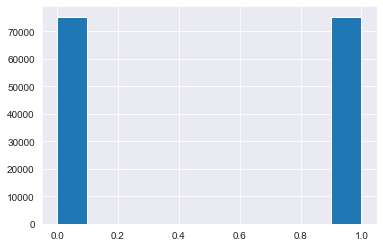

In [54]:
plt.hist(np.array(labels)[:,0])

In [ ]:
CNNv1=tf.keras.Sequential()
CNNv1.add(Input(shape=(numFeat, 1)))
CNNv1.add(BatchNormalization())
CNNv1.add(Conv1D(filters=32,kernel_size=3, strides=2, use_bias=False,padding='same', name='conv_1'))
CNNv1.add(BatchNormalization())
CNNv1.add(Activation('relu'))
# hidden = MaxPooling1D(3, strides=2)(hidden)
CNNv1.add(Conv1D(filters=32,kernel_size=3, strides=2, use_bias=False,padding='same', #was 32
                         name='conv_2'))
CNNv1.add(BatchNormalization())
CNNv1.add(Activation('relu'))
# hidden = MaxPooling1D(3, strides=2)(hidden)
CNNv1.add(Conv1D(filters=32, kernel_size=3, strides=2,padding='same', use_bias=False, #was 32
                         name='conv_3'))
CNNv1.add(BatchNormalization())
CNNv1.add(Activation('relu'))
# hidden = MaxPooling1D(3, strides=2)(hidden)
CNNv1.add(Flatten()) #this is where feature extraction turns to classification
CNNv1.add(Dense(864, activation='relu', name='dense_1'))
CNNv1.add(Dropout(0.5))
CNNv1.add(Dense(1, activation='sigmoid', name='dense_2'))
#dist = Dense(1, activation='sigmoid', name='dense_2')(hidden)
CNNv1.summary()
CNNv1.compile(optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=20, mode='auto', restore_best_weights=True)
history = CNNv1.fit(trainFeatures, trainTargets[:,0],
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()
print(CNNv1.evaluate(testFeatures,testTargets[:,0]))

In [ ]:
predictions=CNNv1.predict(testFeatures)
CNNv1.evaluate(testFeatures,testTargets[:,0])
predictions=np.squeeze(predictions>0.5)
print(recall_score(testTargets[:,0],predictions))
print(precision_score(testTargets[:,0],predictions))
print(f1_score(testTargets[:,0],predictions))

In [ ]:
from research.dataImporting import MLtools
MLtools.save_model(CNNv1,"1DCNN_PL_V1")

In [ ]:
CNNv2=tf.keras.Sequential()
CNNv2.add(Input(shape=(numFeat, 1)))
CNNv2.add(BatchNormalization())
CNNv2.add(Conv1D(filters=8,kernel_size=2, strides=1, use_bias=False,padding='same', name='conv_1'))
CNNv2.add(BatchNormalization())
CNNv2.add(Activation('relu'))
# hidden = MaxPooling1D(3, strides=2)(hidden)
CNNv2.add(Conv1D(filters=16,kernel_size=4, strides=2, use_bias=False,padding='same', #was 32
                         name='conv_2'))
CNNv2.add(BatchNormalization())
CNNv2.add(Activation('relu'))
# hidden = MaxPooling1D(3, strides=2)(hidden)
CNNv2.add(Conv1D(filters=32, kernel_size=6, strides=2,padding='same', use_bias=False, #was 32
                         name='conv_3'))
CNNv2.add(BatchNormalization())
CNNv2.add(Activation('relu'))
# hidden = MaxPooling1D(3, strides=2)(hidden)
CNNv2.add(Flatten()) #this is where feature extraction turns to classification
CNNv2.add(Dense(512, activation='relu', name='dense_1'))
CNNv2.add(Dropout(0.5))
CNNv2.add(Dense(1, activation='sigmoid', name='dense_2'))
#dist = Dense(1, activation='sigmoid', name='dense_2')(hidden)
CNNv2.summary()
CNNv2.compile(optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=20, mode='auto', restore_best_weights=True)
history = CNNv2.fit(trainFeatures, trainTargets[:,0],
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()
print(CNNv2.evaluate(testFeatures,testTargets[:,0]))

In [ ]:
predictions=CNNv2.predict(testFeatures)
CNNv2.evaluate(testFeatures,testTargets[:,0])
predictions=np.squeeze(predictions>0.5)
print(recall_score(testTargets[:,0],predictions))
print(precision_score(testTargets[:,0],predictions))
print(f1_score(testTargets[:,0],predictions))

In [ ]:
CNNv3=tf.keras.Sequential()
CNNv3.add(Input(shape=(numFeat, 1)))
CNNv3.add(BatchNormalization())
CNNv3.add(Conv1D(filters=8,kernel_size=2, strides=1, use_bias=False,padding='same', name='conv_1'))
CNNv3.add(BatchNormalization())
CNNv3.add(Activation('leaky_relu'))
CNNv3.add(Conv1D(filters=16,kernel_size=3, strides=1, use_bias=False,padding='same', #was 32
                         name='conv_2'))
CNNv3.add(BatchNormalization())
CNNv3.add(Activation('leaky_relu'))
CNNv3.add(Conv1D(filters=32, kernel_size=4, strides=2,padding='same', use_bias=False, #was 32
                         name='conv_3'))
CNNv3.add(BatchNormalization())
CNNv3.add(Activation('leaky_relu'))
CNNv3.add(Conv1D(filters=64, kernel_size=4, strides=2,padding='same', use_bias=False, #was 32
                         name='conv_4'))
CNNv3.add(BatchNormalization())
CNNv3.add(Activation('leaky_relu'))
CNNv3.add(Flatten()) #this is where feature extraction turns to classification
CNNv3.add(Dropout(0.3))
CNNv3.add(Dense(1024, activation='leaky_relu', name='dense_1'))
CNNv3.add(Dropout(0.5))
CNNv3.add(Dense(512, activation='leaky_relu', name='dense_2'))
CNNv3.add(Dense(1, activation='sigmoid', name='dense_3'))
#dist = Dense(1, activation='sigmoid', name='dense_2')(hidden)
CNNv3.summary()
CNNv3.compile(optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=20, mode='auto', restore_best_weights=True)
history = CNNv3.fit(trainFeatures, trainTargets[:,0],
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()
print(CNNv3.evaluate(testFeatures,testTargets[:,0]))

In [ ]:
predictions=CNNv3.predict(testFeatures)
CNNv3.evaluate(testFeatures,testTargets[:,0])
predictions=np.squeeze(predictions>0.5)
print("Recall:",recall_score(testTargets[:,0],predictions))
print("P:",precision_score(testTargets[:,0],predictions))
print("f1:,",f1_score(testTargets[:,0],predictions))

In [ ]:
from research.dataImporting import MLtools
MLtools.save_model(CNNv3,"1DCNN_PL_V3(final)")

# SVM Tuning,just gonna assume the hyper-parameters I tuned from before are still valid

In [ ]:
scalar= StandardScaler()
model = svm.SVC(kernel='rbf',C=10,gamma=0.1)
pipeline= Pipeline([('transformer', scalar), ('estimator', model)])
trainFeaturesSVM = np.squeeze(trainFeatures)
testFeaturesSVM = np.squeeze(testFeatures)
# cv = KFold(n_splits=5)
param_grid= {
    'estimator__C':[10], 'estimator__gamma':[0.1]}
print(pipeline.fit(trainFeaturesSVM,trainTargets[:,0]))
pipeline.score(testFeaturesSVM,testTargets[:,0])
search = GridSearchCV(pipeline, param_grid,refit=True,verbose=3, n_jobs=-1,cv=5)




In [ ]:
pipeline_preds=pipeline.predict(testFeaturesSVM)
pipeline_preds=np.squeeze(pipeline_preds>0.5)
print("Acc:",accuracy_score(testTargets[:,0],pipeline_preds))
print("Recall:",recall_score(testTargets[:,0],pipeline_preds))
print("P:",precision_score(testTargets[:,0],pipeline_preds))
print("f1:,",f1_score(testTargets[:,0],pipeline_preds))

In [48]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(pipeline,trainFeaturesSVM,trainTargets[:,0], cv=5)

KeyboardInterrupt: 